In [1]:
try:
	from google.colab import drive

	IN_COLAB = True
	print("Running on Google Colab")
	drive.mount('/content/drive')
except:
	IN_COLAB = False
	print("Not running on Google Colab")

Not running on Google Colab


## Dataset download

In [2]:
if IN_COLAB:
	!pip install git+https://github.com/sign-language-processing/datasets.git -q

In [3]:
import tensorflow_datasets as tfds
# import sign_language_datasets.datasets
from sign_language_datasets.utils.torch_dataset import TFDSTorchDataset
from sign_language_datasets.datasets.config import SignDatasetConfig

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-09 14:44:50.454916: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 14:44:50.454959: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 14:44:50.456216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 14:44:50.463149: I tensorflow/core/platform/cpu_feature_guard.cc:182] This 

In [4]:
DATA_DIR = "/mnt/data3/tfds_slt" if not IN_COLAB else "/content/drive/MyDrive/Académico/Doctorado/SLT Datasets/RWTH"

In [5]:
config = SignDatasetConfig(name="rwth_phoenix2014_t_poses", version="3.0.0", include_video=False, include_pose="holistic")
rwth_phoenix2014_t = tfds.load(name='rwth_phoenix2014_t', builder_kwargs=dict(config=config), data_dir=DATA_DIR)

2024-04-09 14:44:53.957955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 14:44:53.959191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 14:44:53.959415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
train_dataset = TFDSTorchDataset(rwth_phoenix2014_t["train"])
validation_dataset = TFDSTorchDataset(rwth_phoenix2014_t["validation"])
test_dataset = TFDSTorchDataset(rwth_phoenix2014_t["test"])

In [7]:
# import itertools


# for datum in itertools.islice(train_dataset, 0, 5):
# 	print((datum.keys()))
# 	print(f"Pose shape: {datum['pose']['data'].shape}")
# 	print(f"Text: {datum['text'].decode('utf-8')}")
# 	print()

## Dataset analysis

In [8]:
src_lenghts = []
texts = []

for datum in rwth_phoenix2014_t["train"]:
	src_lenghts.append(datum['pose']['data'].shape[0])
	texts.append(datum['text'].numpy().decode('utf-8'))

### Frames analysis for padding and truncation

In [9]:
import pandas as pd


src_lengths_df = pd.Series(src_lenghts)
src_lengths_df.describe(percentiles=[.75, .9, .95, .99])

count    7096.000000
mean      116.594419
std        49.859426
min        16.000000
50%       112.000000
75%       144.000000
90%       182.000000
95%       208.000000
99%       259.000000
max       475.000000
dtype: float64

<Axes: >

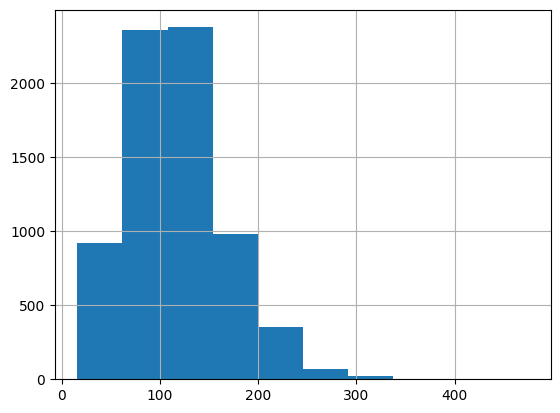

In [10]:
src_lengths_df.hist()

### Text tokenization and analysis for padding and truncation

In [11]:
import torch


class WordLevelTokenizer:

    def __init__(self, texts=None):
        self.token_to_idx = {
            "PAD": 0,
            "UNK": 1,
            "BOS": 2,
            "EOS": 3,
        }
        self.idx_to_token = {
            0: "PAD",
            1: "UNK",
            2: "BOS",
            3: "EOS",
        }
        self.pad_token_id = 0
        self.unk_token_id = 1
        self.cls_token_id = 2
        self.sep_token_id = 3
        self.vocab_size = len(self.token_to_idx)
        if texts is not None:
            self.fit(texts)

    def fit(self, texts):
        for text in texts:
            for word in text.split():
                if word not in self.token_to_idx:
                    self.token_to_idx[word] = len(self.token_to_idx)
                    self.idx_to_token[len(self.idx_to_token)] = word
                    self.vocab_size += 1

    def tokenize(self, text):
        tokens = []
        for word in text.split():
            if word in self.token_to_idx:
                tokens.append(self.token_to_idx[word])
            else:
                tokens.append(self.unk_token_id)
        return tokens

    def __call__(self, texts: list[str], return_tensors=False, padding='max_length', max_length=None):
        tokenized_texts = []
        for text in texts:
            tokenized_text = self.tokenize(text)
            if padding == 'max_length':
                tokenized_text = [self.cls_token_id] + tokenized_text + [self.sep_token_id] + ([self.pad_token_id] * (max_length - (len(tokenized_text) + 2)))
                if len(tokenized_text) > max_length:
                    tokenized_text = tokenized_text[:max_length]
            tokenized_texts.append(tokenized_text)
        if return_tensors == 'pt':
            tokenized_texts = torch.tensor(tokenized_texts)
        return {
            "input_ids": tokenized_texts
        }

    def convert_ids_to_tokens(self, ids):
        return [self.idx_to_token[id] for id in ids]

    def decode(self, ids, skip_special_tokens=False, clean_up_tokenization_spaces=None):
        if skip_special_tokens:
            ids = filter(lambda id: id not in [self.cls_token_id, self.sep_token_id, self.pad_token_id], ids)
        return " ".join(self.convert_ids_to_tokens(ids))

In [12]:
from transformers import AutoTokenizer


USE_BERT_EMBEDDINGS = True

if USE_BERT_EMBEDDINGS:
    TEXT_MODEL = "google-bert/bert-base-german-cased"
    tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
else:
    TEXT_MODEL = None
    tokenizer = WordLevelTokenizer(texts)

In [13]:
BOS_IDX = tokenizer.cls_token_id if tokenizer.cls_token_id is not None else -1
EOS_IDX = tokenizer.sep_token_id if tokenizer.sep_token_id is not None else -1
PAD_IDX = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else -1

print(f"BOS_IDX: {BOS_IDX}, EOS_IDX: {EOS_IDX}, PAD_IDX: {PAD_IDX}")

BOS_IDX: 3, EOS_IDX: 4, PAD_IDX: 0


In [14]:
# tokenized_sequences = tokenizer(texts, padding=True)

In [15]:
# tokens_length = [len(tokens) for tokens in tokenized_sequences['input_ids']]
# print(max(tokens_length))

In [16]:
# print(texts[0])
# print(tokenized_sequences[0].ids)

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch


USE_CLASS_WEIGHTS = False

if USE_CLASS_WEIGHTS:
	flattened_tgts = [item for sublist in tokenized_sequences["input_ids"] for item in sublist if item != PAD_IDX]
	token_ids = sorted(list(set(flattened_tgts)))
	class_weights = compute_class_weight("balanced", classes=np.array(token_ids), y=flattened_tgts)
	class_weights_complete = torch.ones(tokenizer.vocab_size)
	class_weights_complete[token_ids] = torch.from_numpy(class_weights).float()

In [18]:
if USE_CLASS_WEIGHTS:
	print(tokenizer.convert_ids_to_tokens([i for i in range(10)]))
	print(class_weights_complete[:10].tolist())

## Preprocessing and dataloader generation

In [19]:
import torch
from torch import Tensor
import torch.utils.data as utils


MAX_FRAMES = 259
MAX_TOKENS = 80
BATCH_SIZE = 4

LANDMARKS_USED = ["pose", "lhand", "rhand"]
USE_3D = False
NORM_BY_HW = True
# values for RWTH_PHOENIX
HW = (210, 260)

holistic_landmarks = ["pose" for i in range(33)] + ["face" for i in range(468)] + ["lhand" for i in range(21)] + ["rhand" for i in range(21)]
LANDMARKS_MASK = torch.tensor([True if kp in LANDMARKS_USED else False for kp in holistic_landmarks])


def filter_landmarks(datum: Tensor, mask: Tensor, use_3d: bool):
	'''
		Filter landmarks by mask.
		Args:
			datum: Tensor of shape (S, L, D)
			landmarks: list of landmarks to keep
		Returns:
			Tensor of shape (S, L', D)
	'''
	# delete dummy dimension and transpose to (L, S, D) for filtering
	datum = datum.squeeze(1).permute(1, 0, 2)
	datum = datum[mask]
	if not use_3d:
		datum = datum[:, :, :2]
	return datum.permute(1, 0, 2)

def norm_landmarks(datum: Tensor, hw: tuple):
	'''
		Normalize landmarks by HW.
		Args:
			datum: Tensor of shape (S, L, D)
			hw: (H, W)
		Returns:
			Tensor of shape (S, L, D)
	'''
	return datum / torch.tensor(hw).float()

def flatten_landmarks(datum: Tensor):
	'''
		Reshape the pose of datum only keeping the first dimension S (sequence lenght) and flattening the number of landmarks L and their dimensions D.
		Args:
			datum: Tensor of shape (S, D, L)
		Returns:
			Tensor of shape (frames, D * L)
	'''
	return datum.reshape(datum.shape[0], -1)

def pad_truncate_src(datum: Tensor, max_len: int):
	'''Pad the pose to max_len or truncate it'''
	if datum.size(0) < max_len:
		return torch.cat([datum, torch.zeros(max_len - datum.size(0), datum.size(1))])
	else:
		return datum[:max_len]

def collate_fn(batch):
	src = [
		pad_truncate_src(
			flatten_landmarks(
				norm_landmarks(
					filter_landmarks(item['pose']['data'], LANDMARKS_MASK, USE_3D), HW
				)
			), MAX_FRAMES)
	for item in batch]
	src = torch.stack(src)
	tgt = [str(item['text'].decode('utf-8')) for item in batch]
	tgt = tokenizer(tgt, padding='max_length', max_length=MAX_TOKENS, return_tensors='pt')["input_ids"]
	return src, tgt

train_loader = utils.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
validation_loader = utils.DataLoader(validation_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = utils.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [20]:
for src, tgt in train_loader:
  print(src.shape)
  print(tgt.shape)
  break

torch.Size([4, 259, 150])
torch.Size([4, 80])


## Model

### Model definition

In [21]:
if IN_COLAB:
	!pip install lightning -q

In [22]:
import torch
from torch import Tensor


def generate_square_subsequent_mask(size: int, device: torch.device):
    '''
        Generates triangular (size, size) mask for the transformer model.
    '''
    mask = (torch.triu(torch.ones((size, size))) == 1).transpose(0, 1).to(device)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_target_mask(tgt: Tensor, pad_idx: int, device: torch.device):
    '''
        Create target mask and padding mask for the transformer model.
        Args:
            tgt: (N, T) where N is the batch size and T is the target sequence length
            pad_idx: padding index
            device: torch device
        Returns:
            tgt_mask: (T, T), so to evaluate the i-th token, we can only look at the first i tokens, for all i's
            tgt_padding_mask: (N, T), for masking pad tokens
    '''
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask

In [23]:
from torch import Tensor, nn
from torch.nn.functional import relu


class Conv1DEmbedder(nn.Module):

	def __init__(self, in_channels: int, out_channels: int):
		super(Conv1DEmbedder, self).__init__()
		self.conv1d_1 = nn.Conv1d(in_channels, 512, 1)
		self.conv1d_2 = nn.Conv1d(512, 256, 1)
		self.conv1d_3 = nn.Conv1d(256, 128, 1)
		self.conv1d_4 = nn.Conv1d(128, out_channels, 1)

	def forward(self, x: Tensor) -> Tensor:
		'''
			Args:
				x: (N, S, E) where N is the batch size, S is the sequence length and E is the embedding size
			Returns:
				(N, S, E) where E is the embedding size
		'''
		x = x.permute(0, 2, 1)
		x = relu(self.conv1d_1(x))
		x = relu(self.conv1d_2(x))
		x = relu(self.conv1d_3(x))
		x = relu(self.conv1d_4(x))
		return x.permute(0, 2, 1)

In [24]:
import math
import torch
from torch import nn, Tensor


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        '''
        Apply positional encoding to the input tensor.
        Args:
            x: (N, S, E)
        Returns:
            Tensor of shape (N, S, E)
        '''
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [25]:
import math
from torch import nn, Tensor


class TokenEmbedding(nn.Module):
    '''Code taken from https://pytorch.org/tutorials/beginner/translation_transformer.html'''

    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        '''
            Applies token embedding to the target tensor.
            Args:
                tokens: (N, T)
            Returns:
                Tensor of shape (N, T, E)
        '''
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [26]:
from torch import Tensor, nn
from transformers import AutoModel
from torch.nn.functional import softmax


class KeypointsTransformer(nn.Module):
    '''
        Transformer model for sign language translation. It uses a 1D convolutional layer to embed the keypoints and a transformer to translate the sequence.
        S refers to the source sequence length, T to the target sequence length, N to the batch size, and E is the features number.
    '''

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                in_features: int,
                tgt_vocab_size: int,
                d_model: int = 64,
                num_encoder_layers: int = 6,
                dropout: float = 0.1,
                use_bert_embeddings = False,
                ):
        '''
            Args:
                src_max_len: max length of the source sequence
                tgt_max_len: max length of the target sequence
                in_features: number of features of the input (amount of keypoints * amount of coordinates)
                tgt_vocab_size: size of the target vocabulary
                d_model: number of dimensions of the encoding vectors (default=64). Must be even so the positional encoding works.
                kernel_size: the size of the 1D convolution window (default=5)
                keys_initial_emb_size: the size of the keys embedding (default=128)
        '''
        super(KeypointsTransformer, self).__init__()

        self.batch_norm = nn.BatchNorm1d(in_features)
        self.src_keyp_emb = Conv1DEmbedder(in_channels=in_features, out_channels=d_model)
        self.src_pe = PositionalEncoding(d_model=d_model, max_len=src_max_len)
        self.use_bert_embeddings = use_bert_embeddings
        if self.use_bert_embeddings:
            self.tgt_tok_emb = AutoModel.from_pretrained(TEXT_MODEL)
            self.tgt_tok_emb.requires_grad_(False)
            self.tgt_tok_conv_emb = Conv1DEmbedder(in_channels=768, out_channels=d_model)
        else:
            self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, d_model)
        self.tgt_pe = PositionalEncoding(d_model=d_model, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=d_model, num_encoder_layers=num_encoder_layers, dropout=dropout, batch_first=True)
        self.generator = nn.Linear(d_model, tgt_vocab_size)

    def embed_tgt(self, tgt: Tensor):
        if self.use_bert_embeddings:
            tgt_emb = self.tgt_tok_emb(tgt, attention_mask=(tgt == PAD_IDX)).last_hidden_state
            tgt_emb = self.tgt_tok_conv_emb(tgt_emb)
        else:
            tgt_emb = self.tgt_tok_emb(tgt)
        return tgt_emb


    def forward(self,
                src: Tensor,
                tgt: Tensor,
                tgt_mask: Tensor,
                tgt_padding_mask: Tensor
    ):
        '''
            Forward pass of the model.
            Args:
                src: (N, S, E)
                tgt: (N, T, E)
                tgt_mask: (T, T)
                tgt_padding_mask: (N, T)
            Returns:
                Tensor of shape (N, T, tgt_vocab_size)
        '''
        src = src.permute(0, 2, 1)
        src = self.batch_norm(src)
        src = src.permute(0, 2, 1)

        src_emb = self.src_keyp_emb(src)
        src_emb = self.src_pe(src_emb)
        tgt_emb = self.embed_tgt(tgt)
        tgt_emb = self.tgt_pe(tgt_emb)
        # src_mask and src_key_padding_mask are set to none as we use the whole input at every timestep
        outs = self.transformer(
            src = src_emb,
            tgt = tgt_emb,
            src_mask = None,
            tgt_mask = tgt_mask,
            src_key_padding_mask = None,
            tgt_key_padding_mask = tgt_padding_mask)
        # return softmax(self.generator(outs), dim=0)
        return self.generator(outs)

    def encode(self, src: Tensor):
        src_emb = self.src_pe(self.src_keyp_emb(src))
        return self.transformer.encoder(src_emb, None)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt = tgt.to(torch.int64)
        tgt_emb = self.embed_tgt(tgt)
        tgt_emb = self.tgt_pe(tgt_emb)
        return self.transformer.decoder(tgt_emb, memory, tgt_mask)

In [27]:
D_MODEL = 32
NUM_ENCODER_LAYERS = 2
DROPOUT = 0.2

num_keypoints = LANDMARKS_MASK.sum().item()
IN_FEATURES = int(num_keypoints*(3 if USE_3D else 2))

model = KeypointsTransformer(
    src_max_len=MAX_FRAMES,
    tgt_max_len=MAX_TOKENS,
    in_features=IN_FEATURES,
    tgt_vocab_size=tokenizer.vocab_size,
    d_model=D_MODEL,
	  num_encoder_layers=NUM_ENCODER_LAYERS,
    dropout=DROPOUT,
    use_bert_embeddings=USE_BERT_EMBEDDINGS,
)

## Model training

In [28]:
if IN_COLAB:
	!pip install wandb -q

In [29]:
from typing import Literal


def generate_linear_mask(batch_size: int, tgt_len: int, start_index: int, device: torch.device) -> Tensor:
    mask = torch.zeros(batch_size, tgt_len).to(device)
    mask.fill_(float('-inf'))
    mask[:, :start_index] = 0
    return mask

class Translator:
    # TODO: implement batch_greedy_decode and batch_beam_decode

    def __init__(self, model: KeypointsTransformer, tokenizer, device: torch.device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def translate(self, src, method: Literal["greedy", "beam"], k: int = 5) -> str:
        with torch.no_grad():
            if method == "greedy":
                out = self.greedy_decode(src)
            elif method == "beam":
                out = self.beam_decode(src, k)
            else:
                raise ValueError("Invalid method. Choose between 'greedy' and 'beam'.")
        return tokenizer.decode([int(x) for x in out.tolist()], skip_special_tokens=True)

    def greedy_decode(self, src: Tensor) -> Tensor:
        memory = self.model.encode(src)
        ys = torch.ones(1, 1).fill_(BOS_IDX).to(self.device)
        for i in range(MAX_TOKENS-1):
            tgt_mask = generate_square_subsequent_mask(ys.size(1), self.device)
            out = self.model.decode(ys, memory, tgt_mask)
            prob = self.model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()
            ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
            if next_word == EOS_IDX:
                break
        return ys.squeeze()

    def beam_decode(self, src: Tensor, k: int) -> Tensor:
        # We use first dimension corresponding to the batch to predict over the k posible beams
        memory = self.model.encode(src).repeat(k, 1, 1)
        ys = torch.ones(k, 1).fill_(BOS_IDX).to(self.device)
        probs = torch.ones(k, 1).to(self.device)
        for i in range(MAX_TOKENS-1):
            tgt_mask = torch.zeros(ys.size(1), ys.size(1)).to(self.device)
            out = self.model.decode(ys, memory, tgt_mask)
            prob = self.model.generator(out[:, -1])

            next_words_probs, next_words = torch.topk(prob, k=k)

            next_words_joint_probs = (next_words_probs * probs).view(-1)
            next_words_probs = next_words_probs.view(-1)
            next_words = next_words.view(-1)

            sorted_indices = torch.argsort(next_words_joint_probs, descending=True)

            next_words_probs = torch.index_select(next_words_probs, 0, sorted_indices)[:k]
            next_words = torch.index_select(next_words, 0, sorted_indices)[:k]

            probs = next_words_probs.clone()
            ys = torch.cat([ys, next_words.unsqueeze(1)], dim=1)
            if (next_words == EOS_IDX).all():
                break
        return ys[0].squeeze()

In [30]:
import torch
from torch import Tensor
from torch.optim import Adam
from torch.nn.functional import cross_entropy
from torchmetrics import Accuracy
from torchmetrics.functional.text import bleu_score

import lightning as L
import lightning.pytorch.utilities.model_summary.model_summary as model_summary

import pandas as pd


class LKeypointsTransformer(L.LightningModule):

    def __init__(self, model: KeypointsTransformer, num_classes: int, lr = 1e-3):
        super().__init__()
        self.model = model
        self.loss_fn = cross_entropy
        self.lr = lr
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes, ignore_index=PAD_IDX)
        self.translator = Translator(model, tokenizer, self.device)
        self.save_hyperparameters(ignore=['model'])

        self.ys_step = []
        self.beam_translations_step = []
        self.greedy_translations_step = []

        BATCH_SIZE_TEST = 1
        self.example_input_array = (
            torch.randn(BATCH_SIZE_TEST, MAX_FRAMES, IN_FEATURES),
            torch.randint(0, tokenizer.vocab_size, (BATCH_SIZE_TEST, MAX_TOKENS)),
            torch.zeros(MAX_TOKENS, MAX_TOKENS),
            torch.randint(0, 2, (BATCH_SIZE_TEST, MAX_TOKENS)).bool()
        )

    def forward(self, src: Tensor, tgt: Tensor, tgt_mask: Tensor, tgt_padding_mask: Tensor):
        return self.model(src, tgt, tgt_mask, tgt_padding_mask)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        return optimizer

    def run_on_batch(self, batch):
        src, tgt = batch
        # tgt_input and tgt_ouptut are displaced by one position, so tgt_input[i] is the input to the model and tgt_output[i] is the expected output
        tgt_input = tgt[:, :-1]
        tgt_mask, tgt_padding_mask = create_target_mask(tgt_input, PAD_IDX, DEVICE)
        logits = self.model(src, tgt_input, tgt_mask, tgt_padding_mask)
        tgt_output = tgt[:, 1:]
        loss = self.loss_fn(
            logits.reshape(-1, logits.shape[-1]),
            tgt_output.reshape(-1),
            ignore_index=PAD_IDX,
            weight=class_weights_complete.to(DEVICE) if USE_CLASS_WEIGHTS else None,
        )
        accuracy = self.accuracy(logits.reshape(-1, logits.shape[-1]), tgt_output.reshape(-1))
        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_accuracy", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_accuracy", accuracy, on_epoch=True, batch_size=len(batch))
        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.run_on_batch(batch)
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)
        ys, preds_greedy, preds_beam = self.get_translations(batch, batch_idx)
        self.ys_step.extend(ys)
        self.greedy_translations_step.extend(preds_greedy)
        self.beam_translations_step.extend(preds_beam)
        return loss, accuracy

    def on_test_epoch_end(self):
        translation_results = [(y, trans_greedy, trans_beam) +
         tuple(bleu_score(trans_greedy, [y], n_gram=n).item() for n in range(1, 5)) +
         tuple(bleu_score(trans_beam, [y], n_gram=n).item() for n in range(1, 5))
            for y, trans_greedy, trans_beam in zip(self.ys_step, self.greedy_translations_step, self.beam_translations_step)]
        self.ys_step = []
        self.greedy_translations_step = []
        self.beam_translations_step = []
        translation_results_df = pd.DataFrame(translation_results, columns=["y", "trans_greedy", "trans_beam", "bleu_1_greedy", "bleu_2_greedy", "bleu_3_greedy", "bleu_4_greedy", "bleu_1_beam", "bleu_2_beam", "bleu_3_beam", "bleu_4_beam"])
        self.logger.log_table(key="translation-results", columns=list(translation_results_df.columns), data=translation_results)
        self.log("bleu_1_greedy", translation_results_df["bleu_1_greedy"].mean())
        self.log("bleu_2_greedy", translation_results_df["bleu_2_greedy"].mean())
        self.log("bleu_3_greedy", translation_results_df["bleu_3_greedy"].mean())
        self.log("bleu_4_greedy", translation_results_df["bleu_4_greedy"].mean())
        self.log("bleu_1_beam", translation_results_df["bleu_1_beam"].mean())
        self.log("bleu_2_beam", translation_results_df["bleu_2_beam"].mean())
        self.log("bleu_3_beam", translation_results_df["bleu_3_beam"].mean())
        self.log("bleu_4_beam", translation_results_df["bleu_4_beam"].mean())
        translation_results_df.to_csv(f"translation-results-{wandb_logger.experiment.name}.csv", index=False)

    def get_translations(self, batch, batch_idx):
        src, tgt = batch
        preds_greedy = []
        preds_beam = []
        ys = []
        for i in range(len(src)):
            # print(f"Batch {batch_idx}, sample {i}")
            # adds extra dimension representing the batch
            src_0 = src[i].unsqueeze(0)
            preds_greedy.append(self.translator.translate(src_0, method="greedy"))
            preds_beam.append(self.translator.translate(src_0, method="beam"))
            ys.append(tokenizer.decode([int(x) for x in tgt[i].tolist()], skip_special_tokens=True, clean_up_tokenization_spaces=True))
        return ys, preds_greedy, preds_beam

LR = 1e-4
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

l_model = LKeypointsTransformer(model, tokenizer.vocab_size, LR)
model_summary.summarize(l_model, max_depth=10)

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


    | Name                                                                | Type                            | Params | In sizes                                                                                                                       | Out sizes         
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0   | model                                                               | KeypointsTransformer            | 112 M  | [[1, 259, 150], [1, 80], [80, 80], [1, 80]]                                                                                    | [1, 80, 30000]    
1   | model.batch_norm                                                    | BatchNorm1d                     | 300    | [1, 150, 259]                                                             

In [31]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger


PRECISION = 32

wandb_logger = WandbLogger(project="rwth", log_model="all")
wandb_logger.experiment.config.update({
	# System hyperparameters
	"DEVICE": DEVICE,
	"PRECISION": PRECISION,
	# Data hyperparameters
	"BATCH_SIZE": BATCH_SIZE,
	"MAX_FRAMES": MAX_FRAMES,
	"MAX_TOKENS": MAX_TOKENS,
	"TEXT_MODEL": TEXT_MODEL,
	"LANDMARKS_USED": str(LANDMARKS_USED),
	"USE_3D": USE_3D,
	"NORM_BY_HW": NORM_BY_HW,
	# Model hyperparameters
	"D_MODEL": D_MODEL,
	"DROPOUT": DROPOUT,
	"USE_BERT_EMBEDDINGS": USE_BERT_EMBEDDINGS,
	"NUM_ENCODER_LAYERS": NUM_ENCODER_LAYERS,
	# Training hyperparameters
	"USE_CLASS_WEIGHTS": USE_CLASS_WEIGHTS,
	"LR": LR,
})

checkpoint_callback = ModelCheckpoint(
	monitor='val_loss',
	dirpath='checkpoints/',
	filename=f'rwth-{wandb_logger.experiment.name}-best-{{epoch:02d}}-{{step:02d}}-{{val_loss:.2f}}',
	mode='min',
	save_last=True
)
checkpoint_callback.CHECKPOINT_NAME_LAST = f"rwth-{wandb_logger.experiment.name}-last"

trainer = L.Trainer(
    logger=wandb_logger,
    default_root_dir="./checkpoint",
		precision=PRECISION,
    callbacks=[
		EarlyStopping(monitor="val_loss", mode="min", patience=10),
		checkpoint_callback,],
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedroodb (lidiaa). Use `wandb login --relogin` to force relogin


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(
    model=l_model,
    train_dataloaders=train_loader,
    val_dataloaders=validation_loader,
)

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED

wandb: Network error (ReadTimeout), entering retry loop.


In [ ]:
import os
import glob


CHKP = glob.glob(f"checkpoints/rwth-{wandb_logger.experiment.name}-best*")[0]
l_model = LKeypointsTransformer.load_from_checkpoint(CHKP, model=model, num_classes=tokenizer.vocab_size)

trainer.test(
    model=l_model,
	  dataloaders=test_loader,
    ckpt_path=CHKP,
)

In [ ]:
translation_results_df = pd.read_csv(f"translation-results-{wandb_logger.experiment.name}.csv")
translation_results_df.head()